# Machine Translation

German-English

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K


import unicodedata
import re
import numpy as np
import os
import time
import shutil

# 2)- Reading Dataset % quick preprocessing

We will not be using extension step by step as there is a separate file for that. In fact , data is pretty much clean. It is only a double check and to follow all proper steps of preprocessing and data clean

In [0]:
path_to_file = "merged2015.txt"

In [0]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    w = "<start> " + w + " <end>"
    return w

def max_length(t):
    return max(len(i) for i in t)

def create_dataset(path, num_examples):
    lines = open(path, encoding="UTF-8").read().strip().split("\n")
    word_pairs = [[preprocess_sentence(w) for w in l.split("\t")] for l in lines[:num_examples]]
    return word_pairs

def load_dataset(path, num_examples):
    pairs = create_dataset(path, num_examples)
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out

In [0]:
#num_examples = 118000 # Full example set.
num_examples = 30000 # Partial set for faster training
input_data, teacher_data, input_lang, target_lang, len_input, len_target = load_dataset(path_to_file, num_examples)

In [0]:
target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.
p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

BUFFER_SIZE = len(input_data)
BATCH_SIZE = 64
embedding_dim = 256
units = 1024
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)

# Creating the Seq2Seq Model

In [21]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)
encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))
encoder_states = [state_h, state_c]

# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
# Drop-out is added in the dense layers to help mitigate overfitting in this part of the model. Astute developers
# may want to add the same mechanism inside the LSTMs.
decoder_out = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_lstm_out))))

# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
#  encoder_inputs=[batch,encoded_words] from input language (English)
#  decoder_inputs=[batch,encoded_words] from output language (Spanish). This is the "teacher tensor".
#  decoder_out=[batch,encoded_words] from output language (Spanish). This is the "target tensor".
model = Model([encoder_inputs, decoder_inputs], decoder_out)
# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
#  Adam is used because it's, well, the best.
model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 73)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 73, 256)      1851648     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2377216     input_2[0][0]                    
______________________________________________________________________________________________

In [23]:
# Note, we use 20% of our data for validation.
epochs = 10
history = model.fit([input_data, teacher_data], target_data,
                 batch_size=BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)

Train on 5205 samples, validate on 1302 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
5205/5205 [==============================] - 43s 8ms/sample - loss: 2.6352 - sparse_categorical_accuracy: 0.7025 - val_loss: 1.7803 - val_sparse_categorical_accuracy: 0.7649
Epoch 2/10
5205/5205 [==============================] - 42s 8ms/sample - loss: 1.7307 - sparse_categorical_accuracy: 0.7635 - val_loss: 1.7091 - val_sparse_categorical_accuracy: 0.7677
Epoch 3/10
5205/5205 [==============================] - 42s 8ms/sample - loss: 1.6632 - sparse_categorical_accuracy: 0.7664 - val_loss: 1.6548 - val_sparse_categorical_accuracy: 0.7689
Epoch 4/10
5205/5205 [==============================] - 41s 8ms/sample - loss: 1.6405 - sparse_categorical_accuracy: 0.7649 - val_loss: 1.6172 - val_sparse_categorical_accuracy: 0.7694
Epoch 5/10
5205/5205 [==============================] - 41s 8ms/sample - loss: 1.5498 - sparse_categorical_accuracy: 0

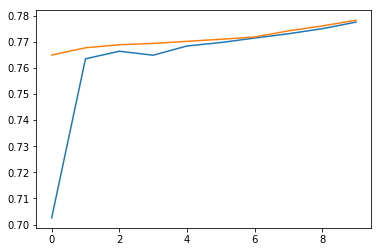

In [24]:
# Plot the results of the training.
plt.plot(history.history['sparse_categorical_accuracy'], label="Training loss")
plt.plot(history.history['val_sparse_categorical_accuracy'], label="Validation loss")
plt.show()

# Inference

In [0]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).
inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units,), name="state_input_h")
state_input_c = Input(shape=(units,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [0]:
# Converts the given sentence (just a string) into a vector of word IDs
# using the language specified. This can be used for either the input (English)
# or target (German) languages.
# Output is 1-D: [timesteps/words]
def sentence_to_vector(sentence, lang):
    pre = preprocess_sentence(sentence)
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
# return a translated string.
def translate(input_sentence, infenc_model, infmodel, attention=False):
    sv = sentence_to_vector(input_sentence, input_lang)
    # Reshape so we can use the encoder model. New shape=[samples,sequence length]
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    # We will continuously feed cur_vec as an input into the decoder to produce the next word,
    # which will be assigned to cur_vec. Start it with "<start>".
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""
    # Start doing the feeding. Terminate when the model predicts an "<end>" or we reach the end
    # of the max target language sentence length.
    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        # This will allow us to accomodate attention models, which we will talk about later.
        if attention:
            x_in += [emb_out]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        # The output of the model is a massive softmax vector with one spot for every possible word. Convert
        # it to a word ID using argmax().
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [0]:
# Let's test out the model! Feel free to modify as you see fit. Note that only words
# that we've trained the model on will be available, otherwise you'll get an error.
#print(translate("india is also reportedly hoping for a deal on defence collaboration between the two nations", encoder_model, inf_model))
